# Plant Diesease Detector

# Description
## The dataset is organized into one folder (Village Plant) and contains subfolders for each image category . There are 20,639 plant with and without diesease images (JPEG) and 15 categories.

# Problem Statement

- Detect Dieseases in Plants

# Constraints
- False Negative , is the biggest constraint for any botany based ML & DL based problems, we need to minimize this.
- Latancy is not the problem as tradition approches takes weeks.

# Benifits
- Predicting damage in eyes without using tradition or having domain expertise

## Importing Liberaries

In [1]:
import numpy as np
import pickle
import cv2
import seaborn as sb
from tqdm import tqdm
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Preparing some variables

In [2]:
BS = 256
EPOCHS = 20
default_image_size = tuple((128, 128))
learning_rate = 0.001
image_size = 0
directory_root = r'C:\Users\Lucifer MorningStar\Documents\Zaid Work\plant'

## Function to Read image from DIR and convert it in array

In [3]:
def convert_image_to_array(image_dir):
    image = cv2.imread(image_dir)
    image = cv2.resize(image, default_image_size)   
    return img_to_array(image)

## Acessing images of all classes and converting it into array and creating list of labels

In [4]:
image_list, label_list = [], []
print("Alert: Initiating Conversion...")
root_dir = listdir(directory_root)
plant_count = {}
for plant_disease_folder in tqdm(root_dir):
    count = 0
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    for image in plant_disease_image_list:
        image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
            count += 1
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(plant_disease_folder)
    plant_count[plant_disease_folder] = count
print("Alert: Conversion Complete.")  

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Alert: Converting Images


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.64s/it]

Alert: Conversion Complete


## Creating One Vs All Label

In [12]:
label_binarizer = LabelBinarizer() 
image_labels = label_binarizer.fit_transform(label_list)
label = label_binarizer.classes_
n_classes = len(label_binarizer.classes_)

## EDA

## Ploting Diffrent Images

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 263.17it/s]


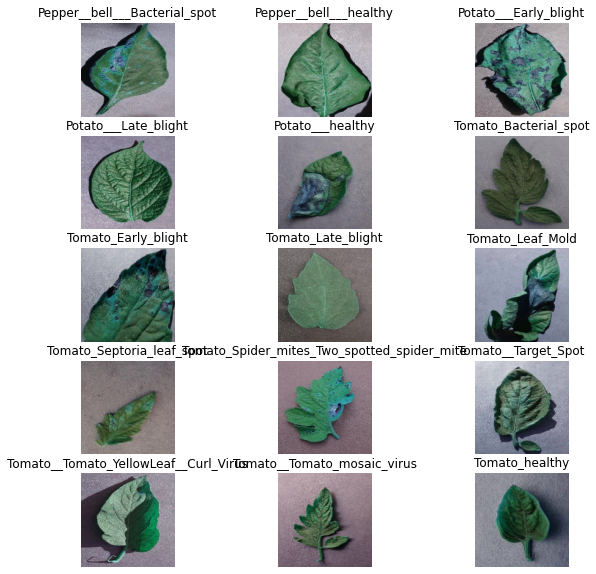

In [6]:
image_samp = []
for plant_disease_folder in tqdm(root_dir):
    plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
    for image in range(1):
        image_directory = f"{directory_root}/{plant_disease_folder}/{plant_disease_image_list[image]}"
    temp = cv2.imread(image_directory)
    cv2.resize(image, default_image_size)
    image_samp.append(cv2.resize(temp, default_image_size))

plt.figure(figsize=(10, 10))
for i in range(len(image_samp)): 
        ax = plt.subplot(5, 3, i + 1)   
        plt.imshow(image_samp[i])   
        plt.title(label[i])  
        plt.axis("off")

## Bar Plot

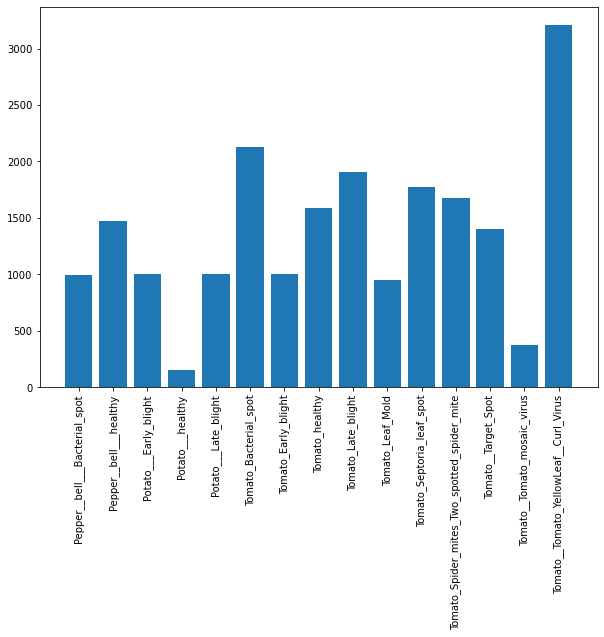

In [7]:
plt.figure(figsize=(10, 7))
plt.bar(x = list(plant_count.keys()), height = list(plant_count.values()))
plt.xticks(rotation = 90)
plt.show()

## PDF plot

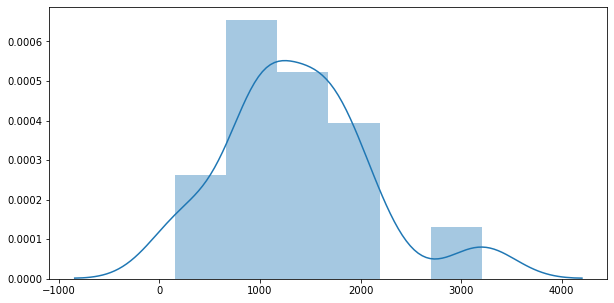

In [8]:
plt.figure(figsize=(10,5))
sb.distplot(list(plant_count.values()))
plt.show()

## Splitting data into Training and Testing

In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("Alert: Spliting into train and test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 69)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state = 69)

Alert: Spliting into train and test


## Image Augumentation

In [10]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

## Transfer Learning/Creating Model

In [13]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=learning_rate, decay=learning_rate / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"]) 

In [16]:
earlystoping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min',
  baseline=None, restore_best_weights=True)
history = model.fit(aug.flow(x_train, y_train, batch_size = BS), validation_data = (x_cv, y_cv),
    steps_per_epoch = 25, epochs = 70, callbacks = [earlystoping], verbose = 1)

Epoch 1/70
25/25 [==============================] - 41s 2s/step - loss: 1.4725 - accuracy: 0.5383 - val_loss: 1.1373 - val_accuracy: 0.6263
Epoch 2/70
25/25 [==============================] - 29s 1s/step - loss: 1.0623 - accuracy: 0.6531 - val_loss: 0.9362 - val_accuracy: 0.6859
Epoch 3/70
25/25 [==============================] - 29s 1s/step - loss: 0.9283 - accuracy: 0.6965 - val_loss: 0.8580 - val_accuracy: 0.7250
Epoch 4/70
25/25 [==============================] - 28s 1s/step - loss: 0.8463 - accuracy: 0.7158 - val_loss: 0.8128 - val_accuracy: 0.7250
Epoch 5/70
25/25 [==============================] - 28s 1s/step - loss: 0.8075 - accuracy: 0.7381 - val_loss: 0.7505 - val_accuracy: 0.7511
Epoch 6/70
25/25 [==============================] - 28s 1s/step - loss: 0.7816 - accuracy: 0.7358 - val_loss: 0.7303 - val_accuracy: 0.7541
Epoch 7/70
25/25 [==============================] - 28s 1s/step - loss: 0.7402 - accuracy: 0.7536 - val_loss: 0.6904 - val_accuracy: 0.7695
Epoch 8/70
25/25 [==

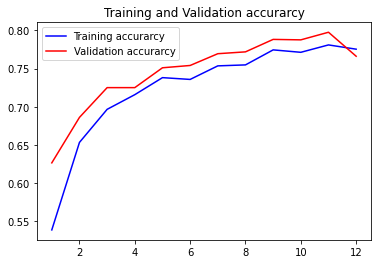

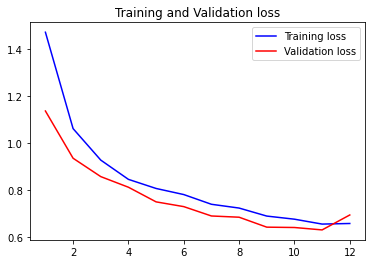

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
print("Alert: Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Alert: Calculating model accuracy
129/129 [==============================] - 5s 37ms/step - loss: 0.6595 - accuracy: 0.7699
Test Accuracy: 76.98643207550049
